133775
133775


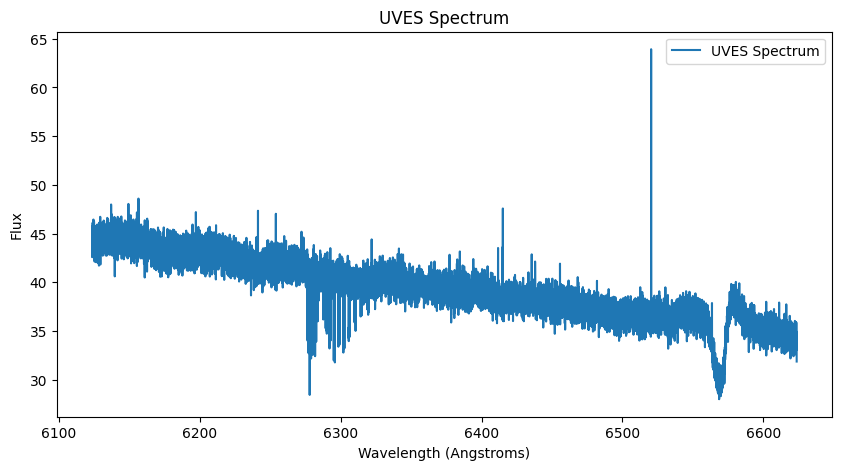

In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits

# Load the FITS file
file_path = "UVES/ADP.2021-09-09T08_23_17.841.fits"
data = fits.getdata(file_path)

# Extract relevant data
wavelength = data['WAVE']
flux = data['FLUX']

print(len(wavelength[0]))
print(len(flux[0]))

# Plot the spectrum
plt.figure(figsize=(10, 5))
plt.plot(wavelength[0][100000:130000], flux[0][100000:130000], label='UVES Spectrum')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('UVES Spectrum')
plt.legend()
plt.show()